Enter the stock name (e.g., CSX): CSX


C:\Windows\Temp\ipykernel_20936\2339267711.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])


Enter the date for prediction (YYYY-MM-DD): 2024-11-25
Using the exact available date: 2024-11-25 for prediction.


C:\Users\sahoo\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0692 - val_loss: 0.0050
Epoch 2/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0095 - val_loss: 0.0012
Epoch 3/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0080 - val_loss: 7.7583e-04
Epoch 4/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0080 - val_loss: 5.6973e-04
Epoch 5/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0067 - val_loss: 5.0745e-04
Epoch 6/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 7/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0056 - val_loss: 0.0010
Epoch 8/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0053 - val_loss: 6.2934e-04
Epoch 9/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 10/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0047 - val_loss: 5.5673e-04
Epoch 11/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 12/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 

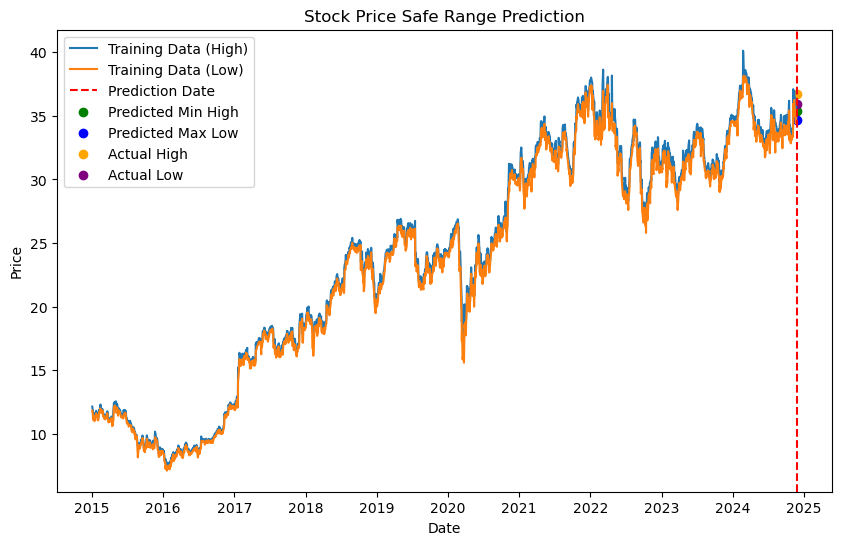

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Function to preprocess the stock data
def preprocess_stock_data(file_path, stock_name):
    # Load the data
    df = pd.read_csv(file_path)
    
    # Standardize stock name and user input
    df['stockname'] = df['stockname'].str.strip().str.upper()
    stock_name = stock_name.strip().upper()
    
    # Filter for the selected stock
    filtered_df = df[df['stockname'] == stock_name]
    if filtered_df.empty:
        raise ValueError(f"No data found for the stock '{stock_name}'. Please check the name.")
    
    # Convert timestamp to datetime
    filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])
    
    # Sort by date
    filtered_df = filtered_df.sort_values(by='timestamp')
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    numeric_cols = filtered_df.select_dtypes(include=['float64', 'int64']).columns
    filtered_df[numeric_cols] = imputer.fit_transform(filtered_df[numeric_cols])
    
    # Add technical indicators
    filtered_df['moving_average'] = filtered_df['high'].rolling(window=5).mean()
    filtered_df['std_dev'] = filtered_df['high'].rolling(window=5).std()
    filtered_df.fillna(method='bfill', inplace=True)  # Fill remaining NaN values
    
    return filtered_df

# Function to prepare data for LSTM
def prepare_lstm_data(df, lookback=60):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['high', 'low', 'moving_average', 'std_dev']])
    
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i])  # Include multiple features
        y.append(scaled_data[i, [0, 1]])  # Targets are 'high' (min) and 'low' (max)
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Function to create the fine-tuned model
def create_fine_tuned_model(input_shape):
    model = Sequential([
        # GRU Layer
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        
        # LSTM Layer
        LSTM(128, return_sequences=False),
        Dropout(0.3),
        
        # Dense Layers
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2)  # Output layer for two targets
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

# Find the exact available date for prediction
def find_exact_date(df, target_date):
    target_date = pd.to_datetime(target_date).normalize()
    if target_date in df['timestamp'].dt.normalize().values:
        return target_date
    else:
        raise ValueError(f"No data available for the exact date {target_date.date()}.")

if __name__ == "__main__":
    # User input for stock name
    stock_name = input("Enter the stock name (e.g., CSX): ")
    
    # Preprocess the data
    data = preprocess_stock_data('stocks.csv', stock_name)
    
    # User input for prediction date
    prediction_date = input("Enter the date for prediction (YYYY-MM-DD): ")
    prediction_date = pd.to_datetime(prediction_date).normalize()
    
    try:
        exact_date = find_exact_date(data, prediction_date)
        print(f"Using the exact available date: {exact_date.date()} for prediction.")
    except ValueError as e:
        print(e)
        exit()
    
    # Filter the data for training
    train_data = data[data['timestamp'] < exact_date]
    test_data = data[data['timestamp'].dt.normalize() == exact_date]
    
    if test_data.empty:
        raise ValueError(f"No data available for the prediction date: {exact_date.date()}")
    
    # Prepare LSTM data
    X_train, y_train, scaler = prepare_lstm_data(train_data, lookback=60)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    
    # Create and train the model
    model = create_fine_tuned_model((X_train.shape[1], X_train.shape[2]))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train, 
        epochs=40, 
        batch_size=32, 
        validation_split=0.2, 
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Prepare test data
    X_test, _, _ = prepare_lstm_data(pd.concat([train_data, test_data]), lookback=60)
    X_test = X_test[-1].reshape((1, X_test.shape[1], X_test.shape[2]))
    
    # Predict on the test data
    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(np.concatenate([predicted_prices, np.zeros((1, 2))], axis=1))[:, :2][0]
    predicted_min_high, predicted_max_low = predicted_prices
    
    # Actual prices on the prediction date
    actual_high = test_data['high'].values[0]
    actual_low = test_data['low'].values[0]
    
    print(f"Prediction Date: {exact_date.date()}")
    print(f"Predicted Minimum High Price: {predicted_min_high:.2f}")
    print(f"Predicted Maximum Low Price: {predicted_max_low:.2f}")
    print(f"Actual High Price: {actual_high:.2f}")
    print(f"Actual Low Price: {actual_low:.2f}")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(train_data['timestamp'], train_data['high'], label="Training Data (High)")
    plt.plot(train_data['timestamp'], train_data['low'], label="Training Data (Low)")
    plt.axvline(x=exact_date, color='r', linestyle='--', label="Prediction Date")
    plt.scatter(exact_date, predicted_min_high, color='g', label="Predicted Min High")
    plt.scatter(exact_date, predicted_max_low, color='b', label="Predicted Max Low")
    plt.scatter(exact_date, actual_high, color='orange', label="Actual High")
    plt.scatter(exact_date, actual_low, color='purple', label="Actual Low")
    plt.title("Stock Price Safe Range Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
